In [1]:

import kagglehub
dataset_path = kagglehub.dataset_download('sukhdayaldhanday/dream-11-fantasy-points-data-of-ipl-all-seasons')

print('Data source import complete.')
dataset_path

Data source import complete.


'C:\\Users\\Avinash\\.cache\\kagglehub\\datasets\\sukhdayaldhanday\\dream-11-fantasy-points-data-of-ipl-all-seasons\\versions\\1'

In [2]:


import torch
import torch.nn as nn
import torch.optim as optim
import pandas as pd
import numpy as np
from sklearn.preprocessing import StandardScaler, LabelEncoder
from torch.utils.data import Dataset, DataLoader
from collections import defaultdict
import torch
import torch.nn as nn
import torch.optim as optim
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from sklearn.preprocessing import OneHotEncoder, LabelEncoder, StandardScaler
from torch.utils.data import Dataset, DataLoader
from sklearn.preprocessing import MinMaxScaler



C:\Users\Avinash\AppData\Local\Programs\Python\Python310\lib\site-packages\torch\utils\_pytree.py:185: FutureWarning: optree is installed but the version is too old to support PyTorch Dynamo in C++ pytree. C++ pytree support is disabled. Please consider upgrading optree using `python3 -m pip install --upgrade 'optree>=0.13.0'`.
  warnings.warn(


In [60]:

class FantasyData(Dataset):
    def __init__(self, df,device):
        self.x, self.y = self.preprocess_data(df)
        self.device = device
    def __len__(self):
        return len(self.x)
    def __getitem__(self, idx):
        return self.x[idx].to(self.device), self.y[idx].to(self.device)
    def proc_new_data(self,df):
        teams = self.team_enc.transform(df[['venue']])

        fullname_idx = self.le.fit_transform(df['fullName'])

        season_scaled = self.scaler.transform(df[['season']])
        season_tensor = torch.tensor(season_scaled, dtype=torch.float32)
        teams_tensor = torch.tensor(teams, dtype=torch.float32)
        name_indices = torch.tensor(fullname_idx, dtype=torch.long)
        name_embeddings = self.fullname_embedding(name_indices)

        # Final features [season + teams + embeddings]
        x = torch.cat([
            season_tensor,
            teams_tensor,
            name_embeddings
        ], dim=1)
        return x

    def preprocess_data(self, df):
        # Targets
        y = torch.tensor(
            df[['Batting_FP', 'Bowling_FP', 'Fielding_FP', 'Total_FP']].values,
            dtype=torch.float32
        )
        print(y)
        # Compute sums for each column
        positive_sums = torch.sum(y * (y > 0), dim=0)  # Sum of positive values
        negative_sums = torch.sum(-y * (y < 0), dim=0)  # Sum of negative values

        # Avoid division by zero by adding a small epsilon
        epsilon = 1e-8
        scale_factors = positive_sums / (negative_sums + epsilon)
        scale_factors = scale_factors.unsqueeze(0) * 0.05  # Shape: (1, 4)

        # Apply scaling only to negative values (correct broadcasting)
        y = torch.where(y < 0, y * scale_factors, y)
        print(y)



        # 1. Encode fullName
        self.le = LabelEncoder()
        fullname_idx = self.le.fit_transform(df['fullName'])
        self.fullname_embedding = nn.Embedding(
            num_embeddings=len(self.le.classes_),
            embedding_dim=16
        )

        # 2. One-hot encode teams
        self.team_enc = OneHotEncoder(sparse_output=False)
        teams = self.team_enc.fit_transform(df[['venue']])

        # 3. Process season
        self.scaler = MinMaxScaler()
        season_scaled = self.scaler.fit_transform(df[['season']])

        # Convert to tensors and combine
        season_tensor = torch.tensor(season_scaled, dtype=torch.float32)
        teams_tensor = torch.tensor(teams, dtype=torch.float32)
        name_indices = torch.tensor(fullname_idx, dtype=torch.long)
        name_embeddings = self.fullname_embedding(name_indices)

        # Final features [season + teams + embeddings]
        x = torch.cat([
            season_tensor,
            teams_tensor,
            name_embeddings
        ], dim=1)
        print(x.shape)
        return x,y






In [50]:
class Model(nn.Module):
    def __init__(self):
        super().__init__()
        self.lin1 = nn.Linear(54,64,bias=True)
        self.lin2 = nn.Linear(64,32,bias=True)
        # self.lin3 = nn.Linear(128,64,bias=True)
        # self.lin4 = nn.Linear(64,32,bias=True)
        self.lin5 = nn.Linear(32,4,bias=True)
        self.relu = nn.ReLU()
        self.sigmoid = nn.Sigmoid()
    def forward(self,x):
        x = self.lin1(x)
        x = self.relu(x)
        x = self.lin2(x)
        x = self.sigmoid(x)
        # x = self.lin3(x)
        # x = self.relu(x)
        # x = self.lin4(x)
        # x = self.relu(x)
        x = self.lin5(x)
        # x = self.relu(x)
        return x



In [51]:
def train(model, train_data_loader, optimizer, loss_fn):
    total_loss = 0.0
    model.train()  # Set the model to training mode

    for data in train_data_loader:
        inputs, labels = data  # Unpack inputs and labels
        inputs = inputs.detach()
        labels = labels.detach()
        optimizer.zero_grad()  # Clear gradients from previous step

        outputs = model(inputs)  # Forward pass
        loss = loss_fn(outputs, labels)  # Compute loss

        loss.backward()  # Backward pass (no need for retain_graph=True)
        optimizer.step()  # Update weights

        total_loss += loss.item()  # Accumulate loss

    # Compute average loss over all batches
    avg_loss = total_loss / len(train_data_loader)

    return avg_loss


In [65]:
df = pd.read_csv(f'{dataset_path}/Final_Fantasy_data.csv')
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
data = FantasyData(df,device)
train_data_loader = DataLoader(data, batch_size=1024,shuffle=True)
criterion  = nn.MSELoss()
model = Model().to(device)
optimizer = optim.AdamW(model.parameters(), lr=0.1)
loss_list = []

tensor([[130.,   0.,   0., 134.],
        [  0.,  83.,   8.,  95.],
        [ 71.,   0.,   0.,  75.],
        ...,
        [  1.,   0.,   0.,   5.],
        [  0.,   0.,   0.,   4.],
        [ -2.,   0.,   0.,   2.]])
tensor([[130.0000,   0.0000,   0.0000, 134.0000],
        [  0.0000,  83.0000,   8.0000,  95.0000],
        [ 71.0000,   0.0000,   0.0000,  75.0000],
        ...,
        [  1.0000,   0.0000,   0.0000,   5.0000],
        [  0.0000,   0.0000,   0.0000,   4.0000],
        [-17.7037,   0.0000,   0.0000,   2.0000]])
torch.Size([22362, 54])


0 864.5441422895951
25 723.402607310902
50 705.5946266867898
75 695.1240484064275
100 685.4908613725142
125 682.2353682084517
150 678.5051158558239
175 674.0546653053977
200 668.4822138006037
225 661.1647255637429
250 661.7649369673295
275 661.171777898615
300 657.3740789240056
325 651.5600336248225
350 652.0627025257457
375 648.4611261541194
400 645.8229148171165
425 641.7513039328835
450 634.4623329856179
475 633.6255576393821


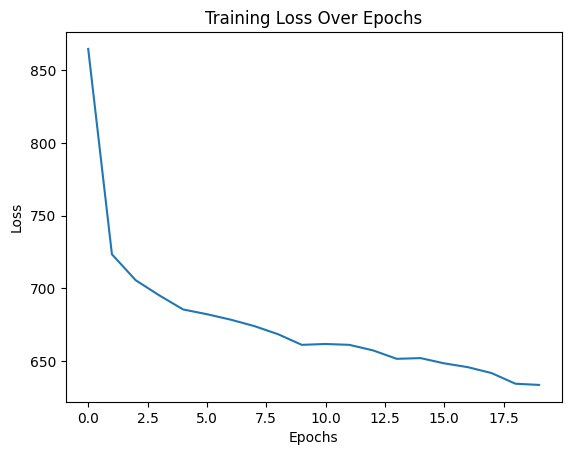

In [66]:
epoch = 500

model.train()
for iter in range(epoch):

    avg_loss = train(model, train_data_loader, optimizer, criterion)

    if iter%25 == 0  :
        print(iter,avg_loss)
        loss_list.append(avg_loss)

plt.plot(loss_list)
plt.title('Training Loss Over Epochs')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.show()



In [79]:
test_data = {
    "fullName": ["MS Dhoni", "Virat Kohli","Virat Kohli","Jasprit Bumrah"],
    "season": [2023, 2025,2023,2022],
    "venue":['MA Chidambaram Stadium, Chepauk, Chennai',"M.Chinnaswamy Stadium, Bengaluru","Wankhede Stadium, Mumbai","Wankhede Stadium, Mumbai"]
}

test = pd.DataFrame(test_data)
test

,fullName,season,venue
0,MS Dhoni,2023,"MA Chidambaram Stadium, Chepauk, Chennai"
1,Virat Kohli,2025,"M.Chinnaswamy Stadium, Bengaluru"
2,Virat Kohli,2023,"Wankhede Stadium, Mumbai"
3,Jasprit Bumrah,2022,"Wankhede Stadium, Mumbai"


In [80]:
test_data_1 = data.proc_new_data(test)

In [81]:
model.eval()
for item in test_data_1:
    print([float(_) for _ in model(item)])

[6.429708480834961, 22.969247817993164, 3.082127332687378, 34.457916259765625]
[25.42748260498047, -2.8234195709228516, 3.705024242401123, 30.39336585998535]
[18.675914764404297, -1.4707671403884888, 3.3883097171783447, 23.222179412841797]
[35.82118225097656, 2.559929132461548, 6.305749893188477, 51.87611389160156]


In [33]:
#Do not re run this
torch.save(model.state_dict() ,"model.pth")

In [145]:
print(device)

cpu


In [146]:
torch.device("cuda" if torch.cuda.is_available() else "cpu")


device(type='cpu')

In [18]:
torch.cuda.is_available()

False

In [19]:
print(torch.__version__)
print(torch.version.cuda)

2.6.0+cpu
None


In [54]:
df[df['fullName']=="MS Dhoni"].head()


,season,match_id,match_name,home_team,away_team,venue,batting_innings,bowling_innings,fullName,Starting_11,Batting_FP,Bowling_FP,Fielding_FP,Total_FP,Dream Team,Captain,Vice Captain
19,2023,1370353,GT v CSK,GT,CSK,"Narendra Modi Stadium, Motera, Ahmedabad",2,1,MS Dhoni,4,-2,0,20,22,0,0,0
80,2023,1370350,CSK v GT,CSK,GT,"MA Chidambaram Stadium, Chepauk, Chennai",1,2,MS Dhoni,4,1,0,0,5,0,0,0
176,2023,1359541,DC v CSK,DC,CSK,"Arun Jaitley Stadium, Delhi",1,2,MS Dhoni,4,5,0,0,9,0,0,0
319,2023,1359535,CSK v KKR,CSK,KKR,"MA Chidambaram Stadium, Chepauk, Chennai",1,2,MS Dhoni,4,2,0,0,6,0,0,0
456,2023,1359529,CSK v DC,CSK,DC,"MA Chidambaram Stadium, Chepauk, Chennai",1,2,MS Dhoni,4,25,0,0,29,0,0,0


In [56]:
df['venue'].unique()

array(['Narendra Modi Stadium, Motera, Ahmedabad',
       'MA Chidambaram Stadium, Chepauk, Chennai',
       'M.Chinnaswamy Stadium, Bengaluru', 'Wankhede Stadium, Mumbai',
       'Eden Gardens, Kolkata', 'Arun Jaitley Stadium, Delhi',
       'Himachal Pradesh Cricket Association Stadium, Dharamsala',
       'Rajiv Gandhi International Stadium, Uppal, Hyderabad',
       'Bharat Ratna Shri Atal Bihari Vajpayee Ekana Cricket Stadium, Lucknow',
       'Sawai Mansingh Stadium, Jaipur',
       'Punjab Cricket Association IS Bindra Stadium, Mohali, Chandigarh',
       'Barsapara Cricket Stadium, Guwahati', 'Brabourne Stadium, Mumbai',
       'Dr DY Patil Sports Academy, Navi Mumbai',
       'Maharashtra Cricket Association Stadium, Pune',
       'Dubai International Cricket Stadium', 'Sharjah Cricket Stadium',
       'Sheikh Zayed Stadium, Abu Dhabi',
       'Dr. Y.S. Rajasekhara Reddy ACA-VDCA Cricket Stadium, Visakhapatnam',
       'Holkar Cricket Stadium, Indore', 'Green Park, Kanpur',
  